# Setup and Preprocessing

## Load code and data

In [1]:
## import code
# basics and plotting
import re
import pandas as pd
import numpy as np
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# preprocessing
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_sample_weight

# cross validation and modeling
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

# tuning
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.model_selection import validation_curve

# staticial comparison of model performance
# see https://github.com/janezd/baycomp
# to install this library, first run the following command in the terminal
# pip install baycomp
from baycomp.single import two_on_single

# feature importance
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
import shap
shap.initjs()

In [2]:
# load original data set into a dataframe
data = pd.read_csv("cleaned_cope_data_randomized.csv", dtype={'b_bstad_me_30_days_8': 'str', 'b_bstad_me_90_days_6': 'str', 'b_bstad_me_90_days_8': 'str'})

In [2]:
# alternatively, load preprocessed data set into a dataframe
data = pd.read_csv('data_preproc.csv')

## Initial Data Exploration, Reduction, and Imputation

In [3]:
# general info including rows and columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2452 entries, 0 to 2451
Columns: 534 entries, b_start_date to b_covid_symptoms_na
dtypes: float64(412), int64(59), object(63)
memory usage: 10.0+ MB


In [4]:
# reduce to columns of interest
# eed scale is named differently with no b_
# data = data[['b_uls_mean', 'b_cdi_mean', 'b_dem_sex', 'b_dem_gender', 'b_dem_orientation', 
#             'b_bads_mean', 'b_shs_mean' , 'b_bhs_mean', 'b_aces_mean' , 'b_mvps_mean', 
#             'eds_events_mean', 'b_gad_mean', 'b_sitbi_2',  'b_sitbi_8', 'b_sitbi_si_month_1', 
#             'b_sitbi_nssi_month_1', 'b_sitbi_nssi_3months_1', 'b_sitbi_nssi_year_1', 
#             'b_sitbi_nssi_life_1','b_sitbi_si_3month_1', 'b_sitbi_si_year_1', 
#             'b_sitbi_si_life_1', 'b_sitbi_plan_3month_1', 'b_sitbi_plan_year_1', 
#             'b_sitbi_plan_life_1', 'b_sitbi_attempt_3months_1', 'b_sitbi_attempt_year_1', 
#             'b_sitbi_attempt_life_1', 'b_sitbi_11', 'b_sitbi_13', 'b_sitbi_16', 'b_sitbi_17', 
#             'b_sitbi_20']]

# reduce to columns of interest (reduced outcomes version)
data = data[['b_uls_mean', 'b_cdi_mean', 'b_dem_sex', 'b_dem_gender', 'b_dem_orientation', 
             'b_bads_mean', 'b_shs_mean' , 'b_bhs_mean', 'b_aces_mean' , 'b_mvps_mean', 
             'eds_events_mean', 'b_gad_mean', 'b_sitbi_2',  'b_sitbi_8', 
             'b_sitbi_nssi_year_1', 'b_sitbi_si_year_1', 'b_sitbi_attempt_year_1', 'b_sitbi_17']]

# more detail about columns of interest 
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2452 entries, 0 to 2451
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   b_uls_mean              2449 non-null   float64
 1   b_cdi_mean              2452 non-null   float64
 2   b_dem_sex               2452 non-null   object 
 3   b_dem_gender            2452 non-null   object 
 4   b_dem_orientation       2452 non-null   object 
 5   b_bads_mean             2451 non-null   float64
 6   b_shs_mean              2452 non-null   float64
 7   b_bhs_mean              2451 non-null   float64
 8   b_aces_mean             2451 non-null   float64
 9   b_mvps_mean             2450 non-null   float64
 10  eds_events_mean         2449 non-null   float64
 11  b_gad_mean              2447 non-null   float64
 12  b_sitbi_2               2451 non-null   float64
 13  b_sitbi_8               2452 non-null   int64  
 14  b_sitbi_nssi_year_1     1604 non-null   

In [5]:
# give columns more intuitive names
data.rename(columns = {'b_uls_mean':'loneliness', 'b_cdi_mean':'depression', 'b_dem_sex':'sex',
                        'b_dem_gender':'gender', 'b_dem_orientation':'orientation', 'b_bads_mean':'behav_act',
                        'b_shs_mean':'hope', 'b_bhs_mean':'hopelessness', 'b_aces_mean':'child_adverse',
                        'b_mvps_mean':'peer_vict', 'eds_events_mean':'discrimination', 
                        'b_gad_mean':'anxiety', 'b_sitbi_2':'nssi_bin', 'b_sitbi_8':'si_bin',
                        'b_sitbi_nssi_year_1':'nssi_year', 'b_sitbi_si_year_1':'si_year',
                        'b_sitbi_attempt_year_1':'attempt_year', 'b_sitbi_17':'attempt_bin'}, inplace = True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2452 entries, 0 to 2451
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   loneliness      2449 non-null   float64
 1   depression      2452 non-null   float64
 2   sex             2452 non-null   object 
 3   gender          2452 non-null   object 
 4   orientation     2452 non-null   object 
 5   behav_act       2451 non-null   float64
 6   hope            2452 non-null   float64
 7   hopelessness    2451 non-null   float64
 8   child_adverse   2451 non-null   float64
 9   peer_vict       2450 non-null   float64
 10  discrimination  2449 non-null   float64
 11  anxiety         2447 non-null   float64
 12  nssi_bin        2451 non-null   float64
 13  si_bin          2452 non-null   int64  
 14  nssi_year       1604 non-null   float64
 15  si_year         1955 non-null   float64
 16  attempt_year    774 non-null    float64
 17  attempt_bin     2452 non-null   i

In [6]:
# missing data counts
data.isnull().sum()

loneliness           3
depression           0
sex                  0
gender               0
orientation          0
behav_act            1
hope                 0
hopelessness         1
child_adverse        1
peer_vict            2
discrimination       3
anxiety              5
nssi_bin             1
si_bin               0
nssi_year          848
si_year            497
attempt_year      1678
attempt_bin          0
dtype: int64

In [7]:
# delete whole samples missing values for nssi_bin, si_bin, or attempt_bin
# these are yes/no target variables with branching logic for whether other target variables were presented
# only nssi_bin has a single missing value
data = data[data['nssi_bin'].notna()]

# confirming drop of 1 sample
data.shape

(2451, 18)

In [8]:
# missing data counts
data.isnull().sum()

loneliness           3
depression           0
sex                  0
gender               0
orientation          0
behav_act            1
hope                 0
hopelessness         1
child_adverse        1
peer_vict            2
discrimination       3
anxiety              5
nssi_bin             0
si_bin               0
nssi_year          848
si_year            497
attempt_year      1677
attempt_bin          0
dtype: int64

In [9]:
# Which missing values for nssi_year can be assumed to be (and imputed as) zero?
print("How many answered no to nssi_bin and are missing value for nssi_year?")
print(data.loc[data['nssi_bin'] == 0, 'nssi_year'].isnull().sum())
print("How many answered yes to nssi_bin and are missing value for nssi_year?")
print(data.loc[data['nssi_bin'] == 1, 'nssi_year'].isnull().sum())

How many answered no to nssi_bin and are missing value for nssi_year?
798
How many answered yes to nssi_bin and are missing value for nssi_year?
50


In [10]:
# Which missing values for si_year can be assumed to be (and imputed as) zero?
print("How many answered no to si_bin and are missing value for si_year?")
print(data.loc[data['si_bin'] == 0, 'si_year'].isnull().sum())
print("How many answered yes to si_bin and are missing value for si_year?")
print(data.loc[data['si_bin'] == 1, 'si_year'].isnull().sum())

How many answered no to si_bin and are missing value for si_year?
461
How many answered yes to si_bin and are missing value for si_year?
36


In [11]:
# Which missing values for attempt_year can be assumed to be (and imputed as) zero?
print("How many answered no to attempt_bin and are missing value for attempt_year?")
print(data.loc[data['attempt_bin'] == 0, 'attempt_year'].isnull().sum())
print("How many answered yes to attempt_bin and are missing value for attempt_year?")
print(data.loc[data['attempt_bin'] == 1, 'attempt_year'].isnull().sum())

How many answered no to attempt_bin and are missing value for attempt_year?
1668
How many answered yes to attempt_bin and are missing value for attempt_year?
9


In [12]:
# replace missing outcome values with zeros where appropriate
# (participant responded they did not engage in the behavior with binary measure)
data.loc[data['nssi_bin'] == 0 & data['nssi_year'].isnull(), 'nssi_year'] = 0
data.loc[data['si_bin'] == 0 & data['si_year'].isnull(), 'si_year'] = 0
data.loc[data['attempt_bin'] == 0 & data['attempt_year'].isnull(), 'attempt_year'] = 0

data.isnull().sum()

loneliness         3
depression         0
sex                0
gender             0
orientation        0
behav_act          1
hope               0
hopelessness       1
child_adverse      1
peer_vict          2
discrimination     3
anxiety            5
nssi_bin           0
si_bin             0
nssi_year         50
si_year           36
attempt_year       9
attempt_bin        0
dtype: int64

In [13]:
# how many unique values per outcome
for c in data.columns:
    print(len(data[c].unique()), "unique values in column", c)

41 unique values in column loneliness
27 unique values in column depression
4 unique values in column sex
189 unique values in column gender
10 unique values in column orientation
48 unique values in column behav_act
45 unique values in column hope
14 unique values in column hopelessness
9 unique values in column child_adverse
36 unique values in column peer_vict
51 unique values in column discrimination
23 unique values in column anxiety
2 unique values in column nssi_bin
2 unique values in column si_bin
112 unique values in column nssi_year
143 unique values in column si_year
19 unique values in column attempt_year
2 unique values in column attempt_bin


In [14]:
# preview data
data.head() 

,loneliness,depression,sex,gender,orientation,behav_act,hope,hopelessness,child_adverse,peer_vict,discrimination,anxiety,nssi_bin,si_bin,nssi_year,si_year,attempt_year,attempt_bin
0,2.25,1.750000,Female,Woman/Girl,Heterosexual/Straight,2.888889,2.166667,2.75,0.6,0.8750,2.9,2.428571,1.0,1,3.0,300.0,0.0,0
1,1.90,1.166667,Female,Woman/Girl,Bisexual,3.555556,3.833333,1.75,0.4,0.0000,3.4,3.142857,1.0,1,0.0,50.0,0.0,0
2,1.80,0.750000,Male,Not sure,Queer,2.444444,2.833333,1.75,0.8,0.2500,3.2,2.571429,1.0,1,25.0,5.0,1.0,1
3,2.15,0.916667,Female,Woman/Girl,Heterosexual/Straight,3.111111,4.333333,1.75,0.8,0.3125,2.3,2.857143,0.0,1,0.0,102.0,0.0,0
4,1.70,0.583333,Female,Woman/Girl,Heterosexual/Straight,2.222222,3.333333,1.00,0.2,0.0000,1.6,1.571429,0.0,0,0.0,0.0,0.0,0


In [15]:
# look at gender values, which need to be recoded
data['gender'].value_counts()

Woman/Girl                                                                                                      1383
Man/Boy                                                                                                          194
Nonbinary                                                                                                        138
Not sure                                                                                                          78
Man/Boy,Transgender,Female to male transgender/FTM,Trans male/Trans masculine                                     71
                                                                                                                ... 
Woman/Girl,Gender expansive,Androgynous                                                                            1
Female to male transgender/FTM,Androgynous,Nonbinary                                                               1
Man/Boy,Transgender,Female to male transgender/FTM,Trans male/Tr

In [16]:
# recode gender values into 3 categories
data.loc[data['gender'] == 'Woman/Girl', 'gender'] = 'woman_only'
data.loc[data['gender'] == 'Man/Boy', 'gender'] = 'man_only'
data.loc[(data['gender'] != 'man_only') & (data['gender'] != 'woman_only'), 'gender'] = 'gender_diverse'

In [17]:
# verify recoding results
data['gender'].value_counts()

woman_only        1383
gender_diverse     874
man_only           194
Name: gender, dtype: int64

## Deeper Data Exploration and Outlier Management

### Features: numeric

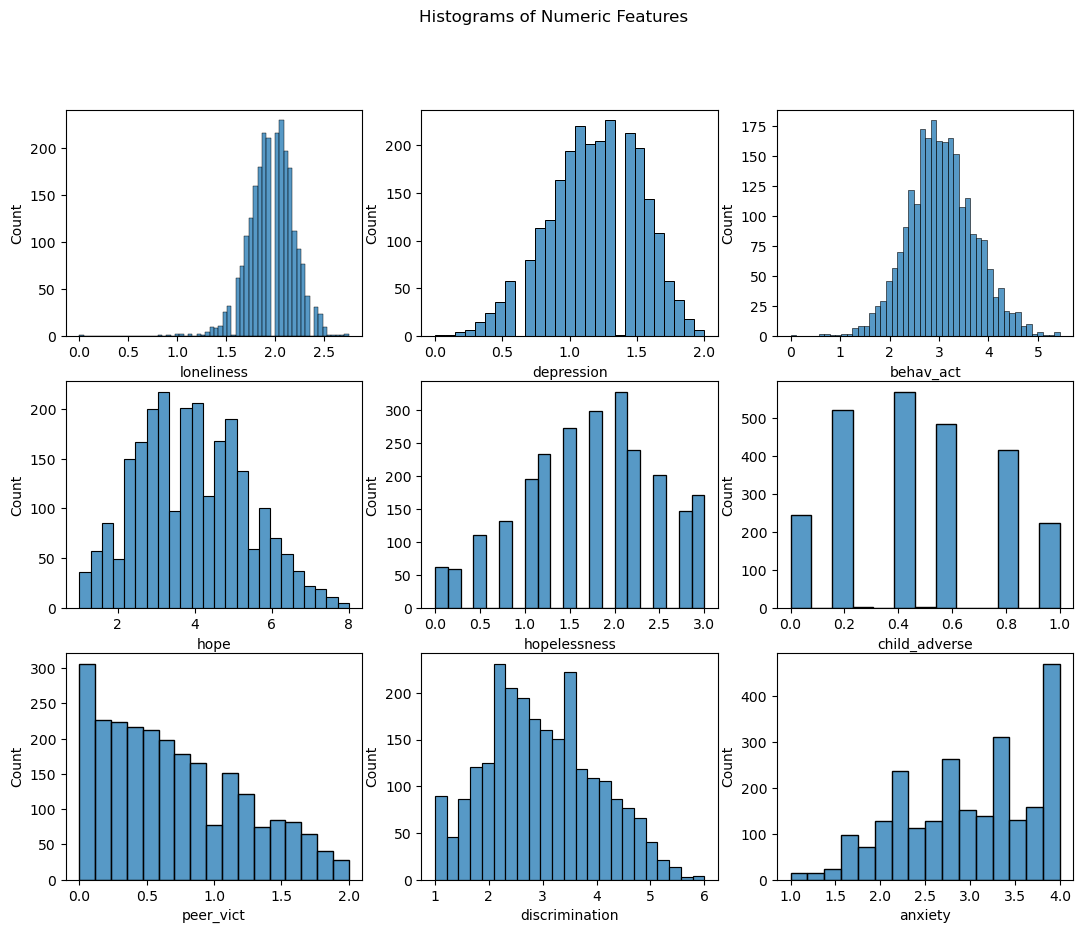

In [18]:
# histograms of numeric features
fig, axes = plt.subplots(3, 3, figsize=(13, 10))
fig.suptitle('Histograms of Numeric Features')

sns.histplot(ax=axes[0, 0], data=data['loneliness'])
sns.histplot(ax=axes[0, 1], data=data['depression'])
sns.histplot(ax=axes[0, 2], data=data['behav_act'])
sns.histplot(ax=axes[1, 0], data=data['hope'])
sns.histplot(ax=axes[1, 1], data=data['hopelessness'])
sns.histplot(ax=axes[1, 2], data=data['child_adverse'])
sns.histplot(ax=axes[2, 0], data=data['peer_vict'])
sns.histplot(ax=axes[2, 1], data=data['discrimination'])
sns.histplot(ax=axes[2, 2], data=data['anxiety'])

# don't show unnecessary output about object
None

In [19]:
# examine correlations between numeric features
numeric_features = ['loneliness', 'depression', 'behav_act', 'hope', 'hopelessness', 
                    'child_adverse', 'peer_vict', 'discrimination', 'anxiety']
data[numeric_features].corr()

,loneliness,depression,behav_act,hope,hopelessness,child_adverse,peer_vict,discrimination,anxiety
loneliness,1.000000,0.142957,0.102703,0.011930,0.076994,0.071869,0.110394,0.126417,0.164725
depression,0.142957,1.000000,-0.129025,-0.562257,0.634654,0.302559,0.322033,0.433495,0.564213
behav_act,0.102703,-0.129025,1.000000,0.323716,-0.107361,-0.035117,0.016811,0.005943,0.101299
hope,0.011930,-0.562257,0.323716,1.000000,-0.594190,-0.188588,-0.174586,-0.238246,-0.274021
hopelessness,0.076994,0.634654,-0.107361,-0.594190,1.000000,0.171762,0.267808,0.340641,0.415289
child_adverse,0.071869,0.302559,-0.035117,-0.188588,0.171762,1.000000,0.264470,0.343200,0.269991
peer_vict,0.110394,0.322033,0.016811,-0.174586,0.267808,0.264470,1.000000,0.625580,0.342849
discrimination,0.126417,0.433495,0.005943,-0.238246,0.340641,0.343200,0.625580,1.000000,0.421498
anxiety,0.164725,0.564213,0.101299,-0.274021,0.415289,0.269991,0.342849,0.421498,1.000000


<AxesSubplot:>

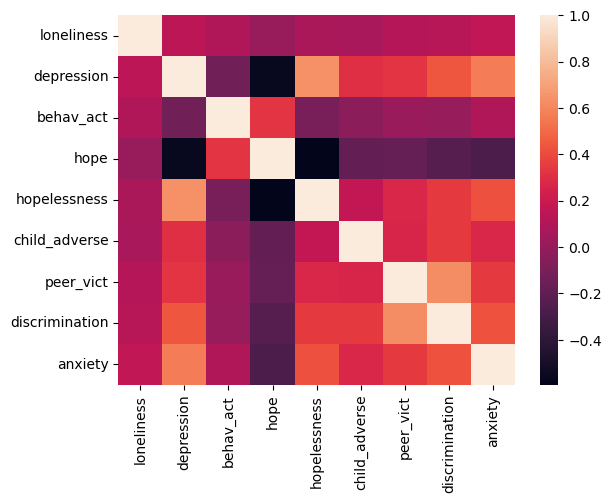

In [20]:
# visualize correlations
sns.heatmap(data[numeric_features].corr())

We can see some expected relationships.  
Strong negative correlations between hope and hopelessness, and between hope and depression  
Strong positive correlations between hopelessness, depression, and anxiety  
Also strong positive correlation between discrimination and peer victimization  
In general, a lot of correlation among predictors

### Features: categorical

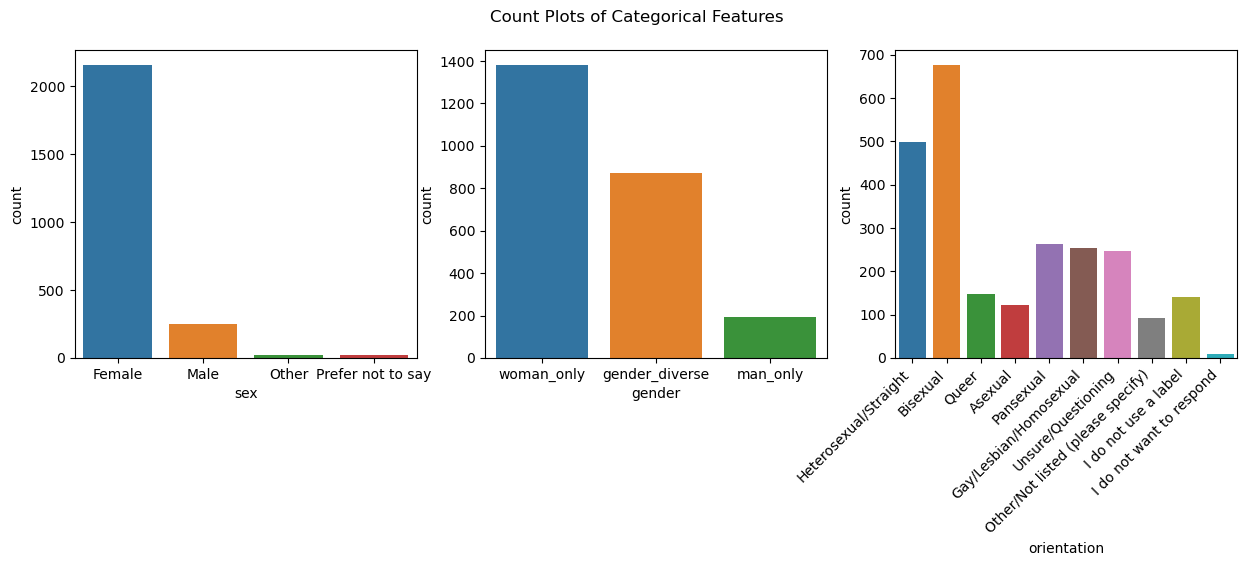

In [21]:
# count plots of categorical features
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('Count Plots of Categorical Features')

sns.countplot(ax=axes[0], x=data['sex'])

sns.countplot(ax=axes[1], x=data['gender'])

sns.countplot(ax=axes[2], x=data['orientation'])

plt.xticks(rotation=45, horizontalalignment='right')
None

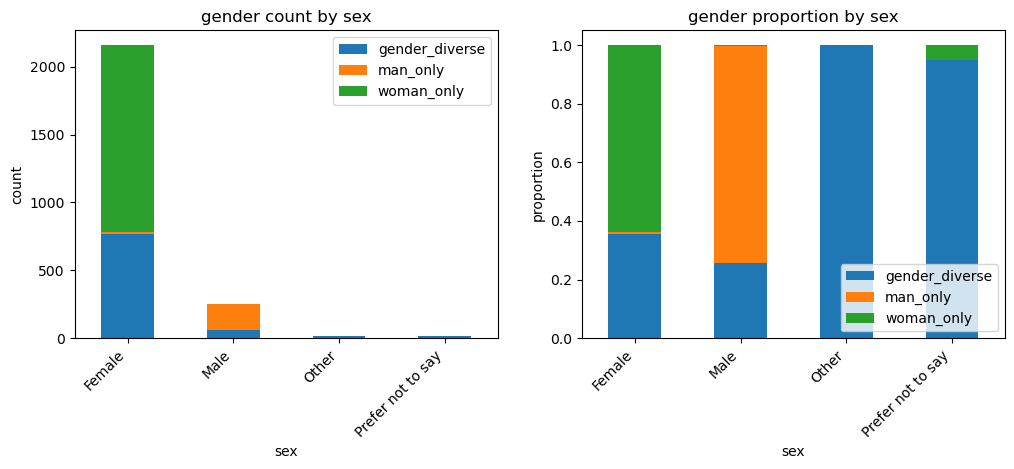

In [22]:
# examining distribution of gender by sex
cross_tab_sex_gender = pd.crosstab(index=data['sex'], columns=data['gender'])
cross_tab_sex_gender_norm = pd.crosstab(index=data['sex'], columns=data['gender'], normalize="index")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

cross_tab_sex_gender.plot(ax=axes[0], kind='bar', stacked=True)
axes[0].legend(loc="upper right", ncol=1)
axes[0].set_xlabel("sex")
axes[0].set_ylabel("count")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].set_title("gender count by sex")

cross_tab_sex_gender_norm.plot(ax=axes[1], kind='bar', stacked=True)
axes[1].legend(loc="lower right", ncol=1)
axes[1].set_xlabel("sex")
axes[1].set_ylabel("proportion")
axes[1].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[1].set_title("gender proportion by sex")

None

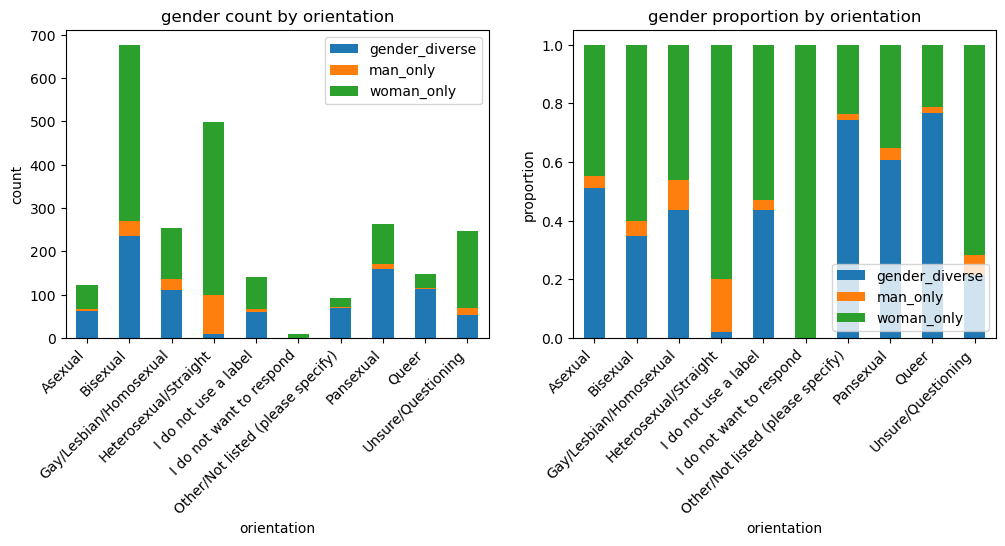

In [23]:
# examining distribution of gender by orientation
cross_tab_orient_gender = pd.crosstab(index=data['orientation'], columns=data['gender'])
cross_tab_orient_gender_norm = pd.crosstab(index=data['orientation'], columns=data['gender'], normalize="index")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

cross_tab_orient_gender.plot(ax=axes[0], kind='bar', stacked=True)
axes[0].legend(loc="upper right", ncol=1)
axes[0].set_xlabel("orientation")
axes[0].set_ylabel("count")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].set_title("gender count by orientation")

cross_tab_orient_gender_norm.plot(ax=axes[1], kind='bar', stacked=True)
axes[1].legend(loc="lower right", ncol=1)
axes[1].set_xlabel("orientation")
axes[1].set_ylabel("proportion")
axes[1].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[1].set_title("gender proportion by orientation")

None

### Targets: numeric

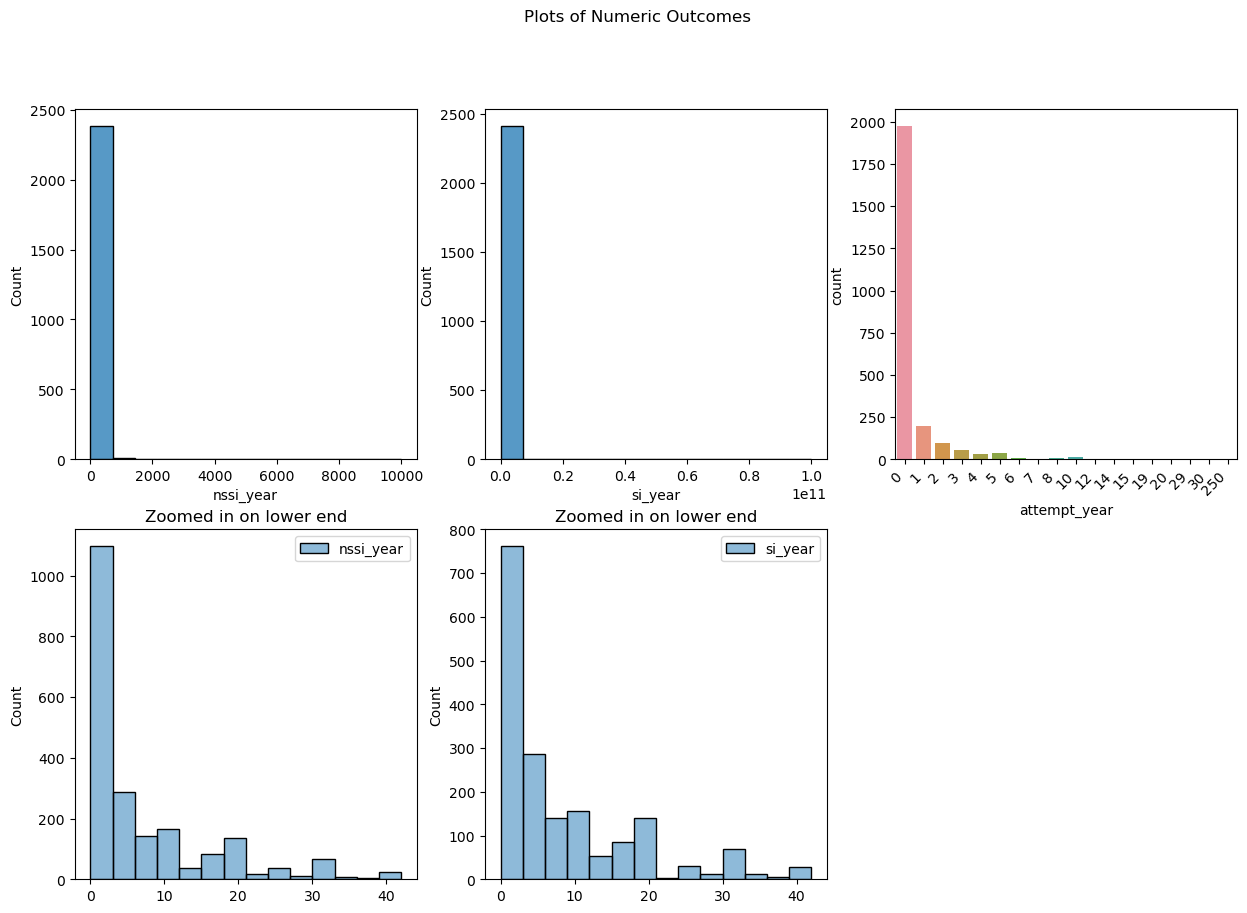

In [24]:
# plots of numeric targets
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Plots of Numeric Outcomes')

sns.histplot(ax=axes[0, 0], data=data['nssi_year'], bins=14)

sns.histplot(ax=axes[0, 1], data=data['si_year'], bins=14)

sns.countplot(ax=axes[0, 2], x=data.loc[data['attempt_year'].notna(), 'attempt_year'].astype('int'))
plt.sca(axes[0, 2])
plt.xticks(rotation=45, horizontalalignment='right')

sns.histplot(ax=axes[1, 0], data=data.loc[data['nssi_year'] < 43, ['nssi_year']], bins=14)
axes[1, 0].set_title("Zoomed in on lower end")

sns.histplot(ax=axes[1, 1], data=data.loc[data['si_year'] < 43, ['si_year']], bins=14)
axes[1, 1].set_title("Zoomed in on lower end")

fig.delaxes(axes[1, 2])

None

In [25]:
# examine correlations between outcome variables
data[['nssi_year', 'si_year', 'attempt_year']].corr()

,nssi_year,si_year,attempt_year
nssi_year,1.000000,0.049948,0.068214
si_year,0.049948,1.000000,0.012383
attempt_year,0.068214,0.012383,1.000000


<AxesSubplot:>

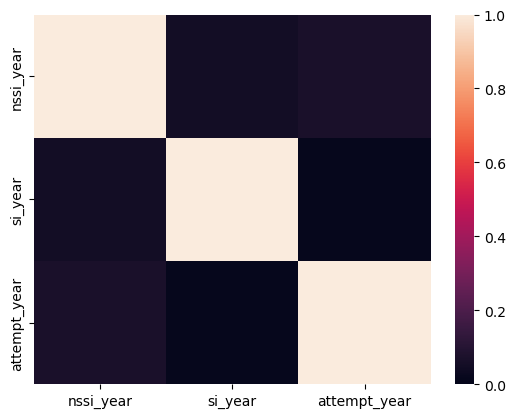

In [26]:
# visualize correlations
sns.heatmap(data[['nssi_year', 'si_year', 'attempt_year']].corr(), vmin=0, vmax=1)

Suprisingly little correlation between numeric outcome variables?

In [27]:
# limit some extremely large response values for outcome year variables
# to avoid issues related to extreme outliers and/or unrealistic values

# for nssi, 1000 would correspond roughly to average of 3 per day
data.loc[data['nssi_year'] > 1000, 'nssi_year'] = 1000

# same for si
data.loc[data['si_year'] > 1000, 'si_year'] = 1000

# for attempt, only one value greater than 30, will cap at 50
data.loc[data['attempt_year'] > 30, 'attempt_year'] = 50

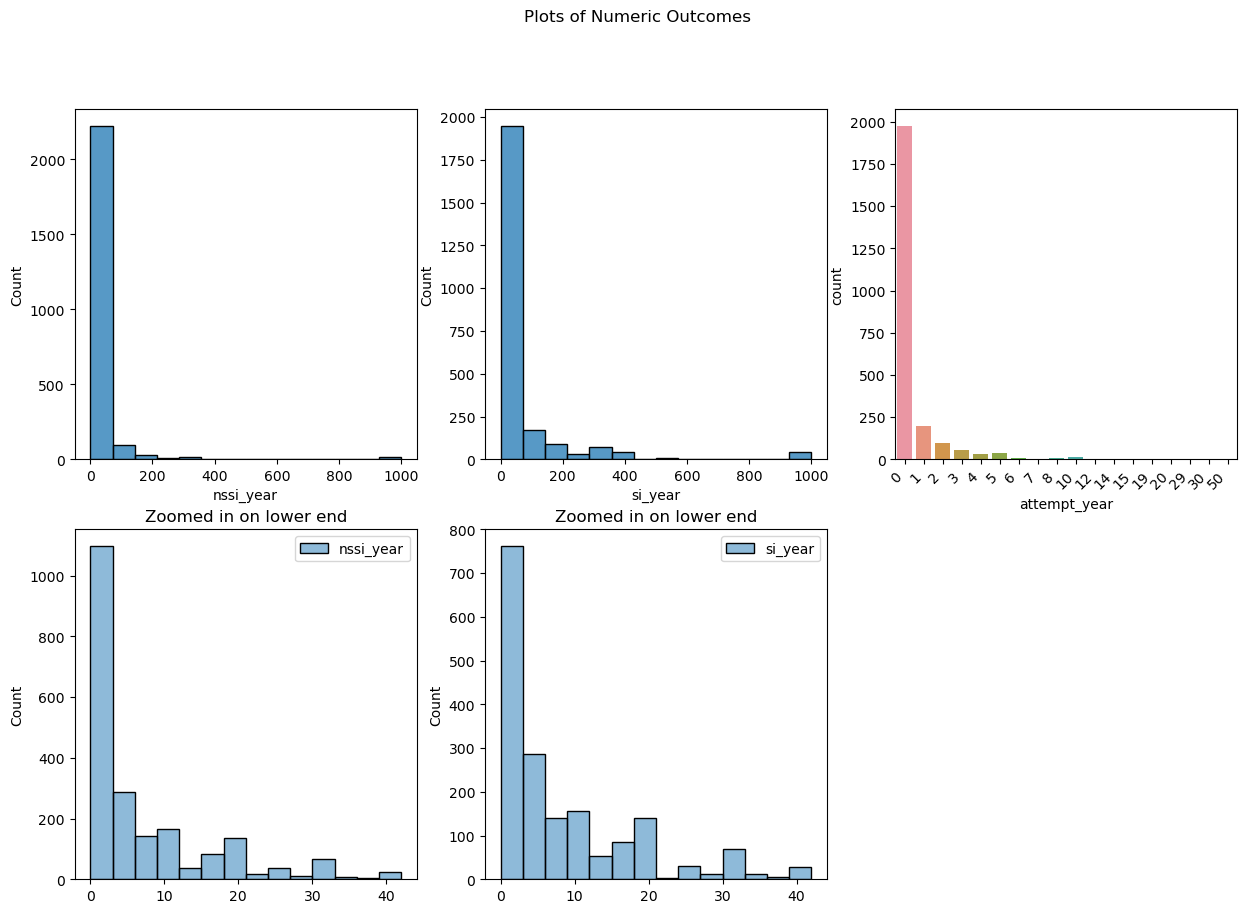

In [28]:
# redo plots and correations of outcomes after constraining outliers
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Plots of Numeric Outcomes')

sns.histplot(ax=axes[0, 0], data=data['nssi_year'], bins=14)

sns.histplot(ax=axes[0, 1], data=data['si_year'], bins=14)

sns.countplot(ax=axes[0, 2], x=data.loc[data['attempt_year'].notna(), 'attempt_year'].astype('int'))
plt.sca(axes[0, 2])
plt.xticks(rotation=45, horizontalalignment='right')

sns.histplot(ax=axes[1, 0], data=data.loc[data['nssi_year'] < 43, ['nssi_year']], bins=14)
axes[1, 0].set_title("Zoomed in on lower end")

sns.histplot(ax=axes[1, 1], data=data.loc[data['si_year'] < 43, ['si_year']], bins=14)
axes[1, 1].set_title("Zoomed in on lower end")

fig.delaxes(axes[1, 2])

None

In [29]:
data[['nssi_year', 'si_year', 'attempt_year']].corr()

,nssi_year,si_year,attempt_year
nssi_year,1.000000,0.313511,0.165091
si_year,0.313511,1.000000,0.229054
attempt_year,0.165091,0.229054,1.000000


<AxesSubplot:>

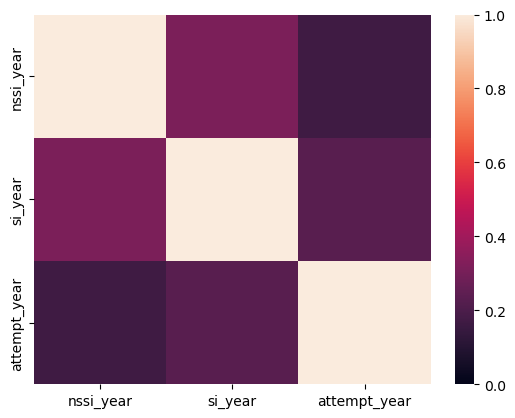

In [30]:
sns.heatmap(data[['nssi_year', 'si_year', 'attempt_year']].corr(), vmin=0, vmax=1)

Constraining outliers did increase correlations, but they are still small-to-moderate.

### Targets: categorical

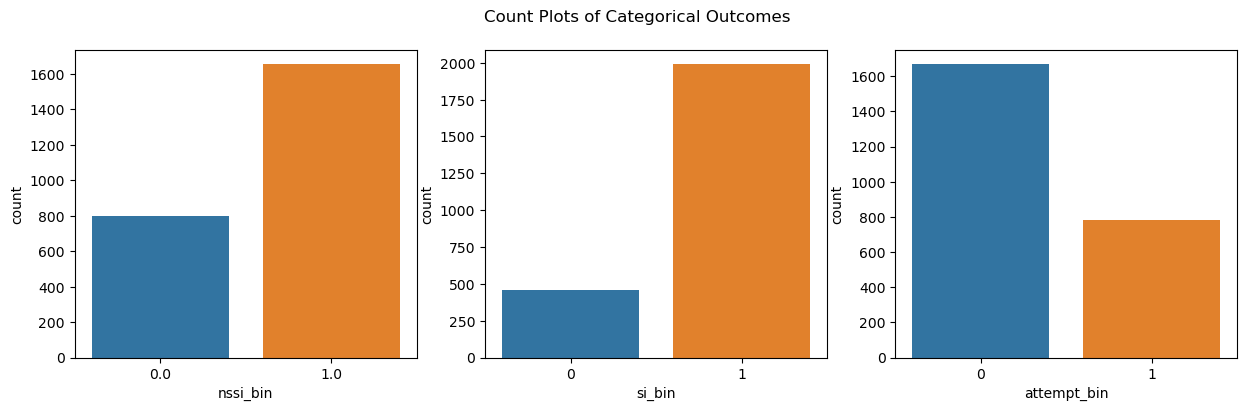

In [31]:
# count plots of categorical target variables

# count plots of categorical features
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('Count Plots of Categorical Outcomes')

sns.countplot(ax=axes[0], x=data['nssi_bin'])

sns.countplot(ax=axes[1], x=data['si_bin'])

sns.countplot(ax=axes[2], x=data['attempt_bin'])

None

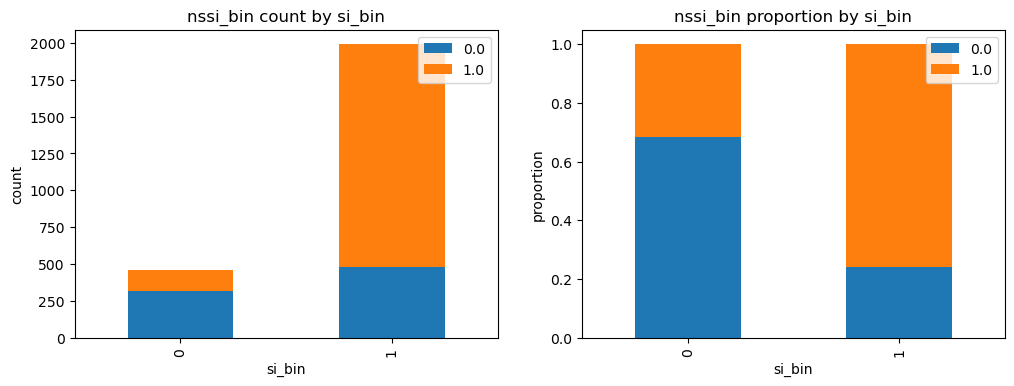

In [32]:
# examining distribution of si_bin by nssi_bin
cross_tab_si_nssi = pd.crosstab(index=data['si_bin'], columns=data['nssi_bin'])
cross_tab_si_nssi_norm = pd.crosstab(index=data['si_bin'], columns=data['nssi_bin'], normalize="index")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

cross_tab_si_nssi.plot(ax=axes[0], kind='bar', stacked=True)
axes[0].legend(loc="upper right", ncol=1)
axes[0].set_xlabel("si_bin")
axes[0].set_ylabel("count")
axes[0].set_title("nssi_bin count by si_bin")

cross_tab_si_nssi_norm.plot(ax=axes[1], kind='bar', stacked=True)
axes[1].legend(loc="upper right", ncol=1)
axes[1].set_xlabel("si_bin")
axes[1].set_ylabel("proportion")
axes[1].set_title("nssi_bin proportion by si_bin")

None

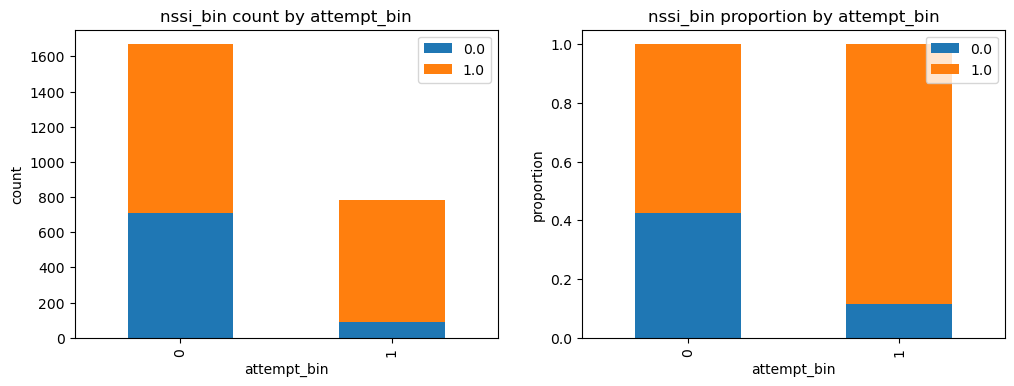

In [33]:
# examining distribution of attempt_bin by nssi_bin
cross_tab_attempt_nssi = pd.crosstab(index=data['attempt_bin'], columns=data['nssi_bin'])
cross_tab_attempt_nssi_norm = pd.crosstab(index=data['attempt_bin'], columns=data['nssi_bin'], normalize="index")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

cross_tab_attempt_nssi.plot(ax=axes[0], kind='bar', stacked=True)
axes[0].legend(loc="upper right", ncol=1)
axes[0].set_xlabel("attempt_bin")
axes[0].set_ylabel("count")
axes[0].set_title("nssi_bin count by attempt_bin")

cross_tab_attempt_nssi_norm.plot(ax=axes[1], kind='bar', stacked=True)
axes[1].legend(loc="upper right", ncol=1)
axes[1].set_xlabel("attempt_bin")
axes[1].set_ylabel("proportion")
axes[1].set_title("nssi_bin proportion by attempt_bin")

None

In [34]:
# save final dataframe to csv to bypass this preprocessing in the future 
data.to_csv('data_preproc.csv', index=False)

# Modeling

## nssi_bin

In [3]:
# define target
target = data['nssi_bin']

# define features
features = data[['loneliness', 'depression', 'sex', 'gender', 'orientation', 'behav_act',
                   'hope', 'hopelessness', 'child_adverse', 'peer_vict', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

# define imputer
imputer = KNNImputer(n_neighbors=5)

# define cross validation procedure
cross_val = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=0)

### Dummy Baseline Model

In [4]:
# always predict most frequent target class
dummy_results = cross_validate(DummyClassifier(), features, target, cv=cross_val)
print('The mean accuracy with cross-validation is: ' 
      f'{dummy_results["test_score"].mean():.3f} +/- {dummy_results["test_score"].std():.3f}') 

The mean accuracy with cross-validation is: 0.674 +/- 0.002


### Logistic Regression Model

In [4]:
# define preprocessor to encode categorical features and scale numeric features
preprocessor = ColumnTransformer([
    ('categorical', OneHotEncoder(handle_unknown = 'ignore'), categorical_columns), 
    ('numeric', StandardScaler(), numeric_columns)])

In [5]:
# define algorithm
logreg = LogisticRegression(class_weight='balanced', random_state=0)

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, logreg)

In [6]:
# hyperparameter tuning
# hyperparameter values to try
param_grid =  {
    'logisticregression__C': [0.1, 0.5, 1, 2, 5, 10]}

grid_search = GridSearchCV(pipeline, param_grid=param_grid, n_jobs=2)

cv_results = cross_validate(grid_search, features, target, n_jobs=2, return_estimator=True)

In [7]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with accuracy of {cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'logisticregression__C': 0.1}
with accuracy of 0.695
Best hyperparameters for split #2:
{'logisticregression__C': 2}
with accuracy of 0.667
Best hyperparameters for split #3:
{'logisticregression__C': 0.5}
with accuracy of 0.688
Best hyperparameters for split #4:
{'logisticregression__C': 0.1}
with accuracy of 0.708
Best hyperparameters for split #5:
{'logisticregression__C': 0.1}
with accuracy of 0.680


0.1 is probably best, but let's examine validation curve

In [8]:
# generate validation curve for n_estimators
C_values = [0.01, 0.1, 0.3, 0.5, 0.8, 1, 2]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='logisticregression__C', param_range=C_values, scoring='accuracy', n_jobs=2)

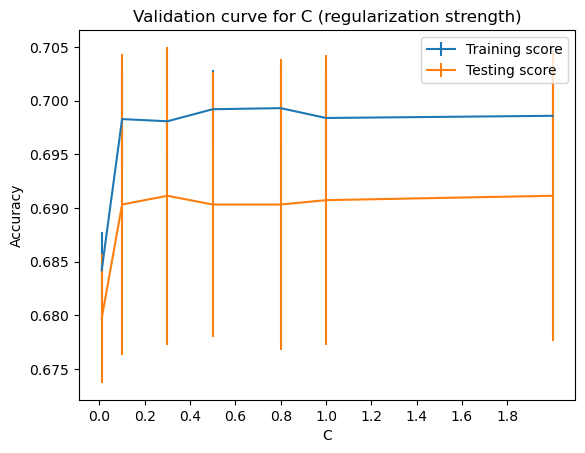

In [9]:
# plot validation curve for n_estimators
plt.errorbar(C_values, train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(C_values, test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 2, 0.2))
plt.xlabel("C")
plt.ylabel("Accuracy")
_ = plt.title("Validation curve for C (regularization strength)")

It seems C of 0.3 might be slightly better

In [6]:
# set C to 0.3
pipeline.set_params(logisticregression__C=0.3)

# get results from tuned model
logreg_results = cross_validate(pipeline, features, target, cv=cross_val)

In [7]:
print('The mean accuracy with cross-validation is: ' 
      f'{logreg_results["test_score"].mean():.3f} +/- {logreg_results["test_score"].std():.3f}') 

The mean accuracy with cross-validation is: 0.690 +/- 0.030


((0.009752272340323703, 0.3002283946718435, 0.6900193329878328), <Figure size 640x480 with 1 Axes>)


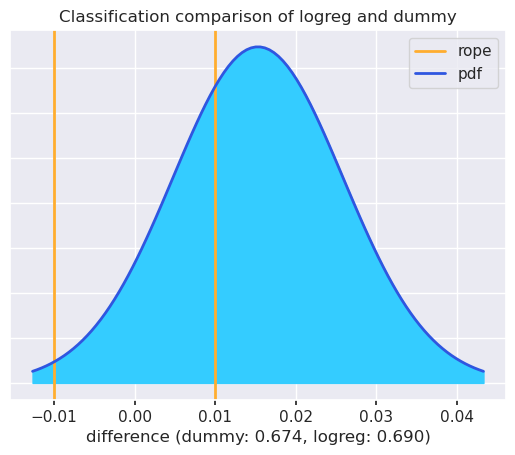

In [13]:
# statistical tests comparing performance
logreg_vs_dummy = two_on_single(x=dummy_results["test_score"], y=logreg_results["test_score"], 
                                rope=0.01, runs=10, names=('dummy', 'logreg'), plot=True)
plt.title("Classification comparison of logreg and dummy")
print(logreg_vs_dummy)

           feature      mean       std
1       depression  0.035642  0.011989
4      orientation  0.029735  0.004750
2              sex  0.027291  0.007739
3           gender  0.014868  0.009201
5        behav_act  0.010998  0.003991
10  discrimination  0.008147  0.010738
0       loneliness  0.007536  0.006314
7     hopelessness  0.006517  0.005295
8    child_adverse  0.005295  0.006706
6             hope  0.003259  0.010151
9        peer_vict  0.002444  0.002993
11         anxiety  0.002240  0.006405


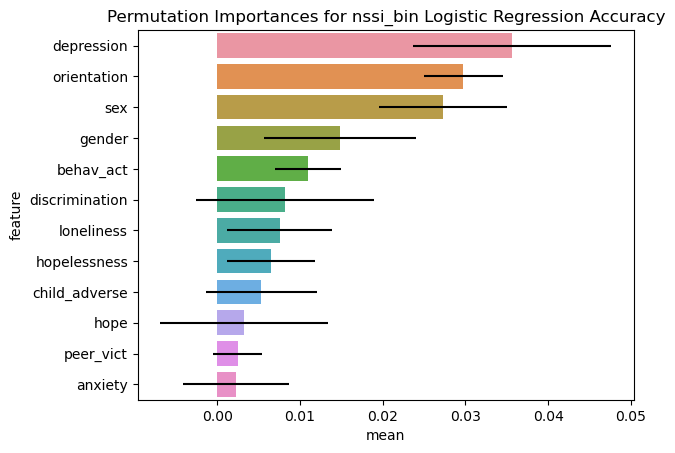

In [8]:
# split data for permutation importance computation
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=0)

# permutation importance computation
pipeline.fit(X_train, y_train)
perm_results = permutation_importance(pipeline, X_test, y_test, n_repeats=10, random_state=0, n_jobs=2)

# store results in a dataframe and sort
perm_results_df = pd.DataFrame()
perm_results_df['feature'] = X_test.columns
perm_results_df['mean'] = perm_results.importances_mean
perm_results_df['std'] = perm_results.importances_std
perm_results_df.sort_values('mean', ascending=False, inplace=True)

# view results
print(perm_results_df)
plt.title("Permutation Importances for nssi_bin Logistic Regression Accuracy")
sns.barplot(x=perm_results_df['mean'], y=perm_results_df['feature'], xerr=perm_results_df['std'])

None

In [9]:
## SHAP value computation

# recreate pipeline without the model and preprocess train and test data
shap_pipeline = make_pipeline(preprocessor, imputer)
shap_X_train = shap_pipeline.fit_transform(X_train)
shap_X_test = shap_pipeline.transform(X_test)

# get feature names after preprocessing
feature_names = [i.split('__')[1] for i in shap_pipeline.get_feature_names_out()]

# fit model
logreg.fit(shap_X_train, y_train)

# get original SHAP values
explainer = shap.Explainer(logreg, shap_X_train, feature_names=feature_names)
shap_values = explainer(shap_X_test)

## create a version of SHAP values where one-hot encoded categoricals are
## collapsed (summed) back into a single value per categorical variable

# create breaking points to define which variables to sum together
n_categories_cat = features[categorical_columns].nunique()
n_categories_num = pd.Series(index=numeric_columns, dtype='int64')
n_categories_num[:] = 1
n_categories = pd.concat([n_categories_cat, n_categories_num]).astype(int)
n_categories = n_categories[:-1]

# compute sums (SHAP values for numeric features are not summed with 
# anything so they remain unchanged)
collapsed = []
for values in shap_values.values:
    values_split = np.split(values, np.cumsum(n_categories))
    values_sum = [sum(l) for l in values_split]
    collapsed.append(values_sum)
    
# create a new copy of the full SHAP values object 
# we will alter this copy while also retaining the original
# the original is helpful for understanding how specific values
# for the categorical features affect the overall prediction
# while the collapsed version is helpful for understanding the 
# importance of each categorical feature as a whole
shap_values_collapsed = explainer(shap_X_test)
shap_values_collapsed.values = np.array(collapsed)
collapsed_feature_names = list(categorical_columns) + list(numeric_columns)
shap_values_collapsed.data = np.array(X_test[collapsed_feature_names])
shap_values_collapsed.feature_names = collapsed_feature_names

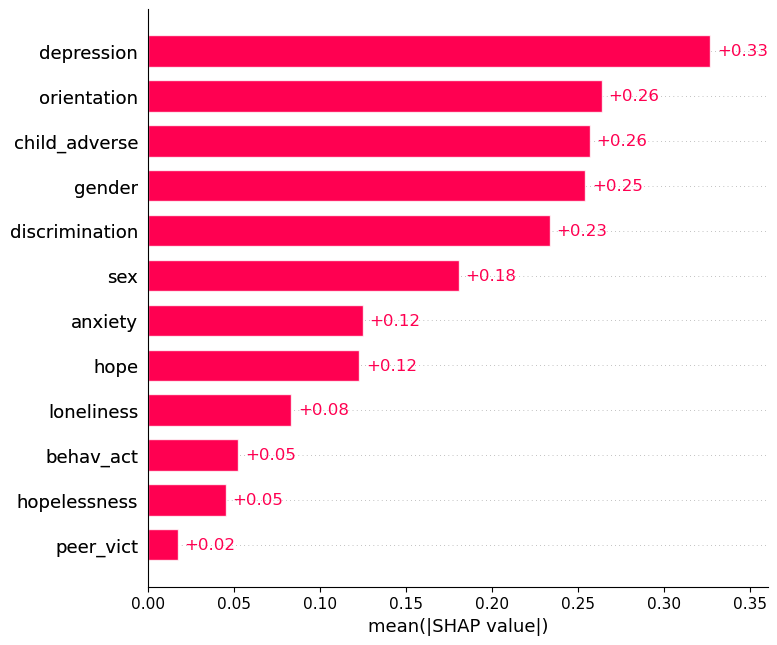

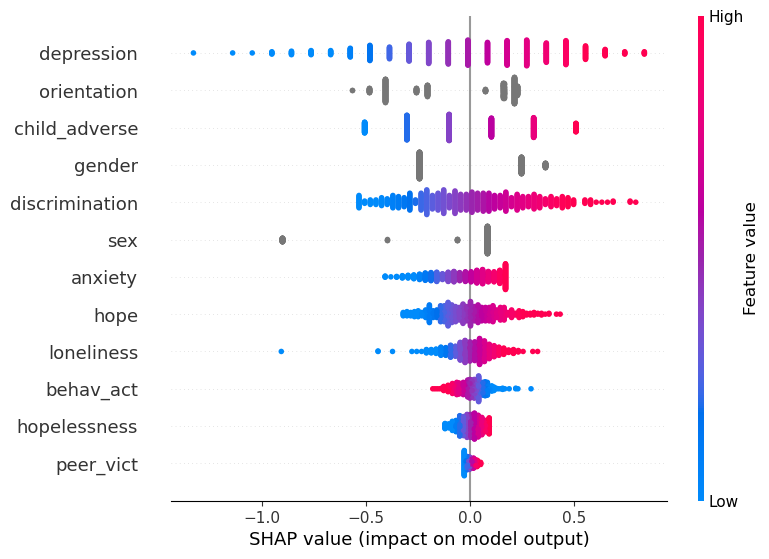

In [10]:
# individual case plot
# shap.plots.waterfall(shap_values[0], max_display=len(feature_names))

# aggregate plots
shap.plots.bar(shap_values_collapsed, max_display=len(collapsed_feature_names))
shap.plots.beeswarm(shap_values_collapsed, max_display=len(collapsed_feature_names))

### Random Forest Model

In [10]:
# define preprocessor to encode categorical features
preprocessor = ColumnTransformer([
    ('categorical', OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1), categorical_columns)], 
    remainder = 'passthrough')

In [45]:
# hyperparameter tuning
# define algorithm
rfc = RandomForestClassifier(n_jobs=2, random_state=0, class_weight='balanced')

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, rfc)

# hyperparameter values to try
param_grid =  {
    'randomforestclassifier__n_estimators': [100, 500, 1000], 
    'randomforestclassifier__max_leaf_nodes': [8, 16, 32, 64, 128, 256]}

grid_search = GridSearchCV(pipeline, param_grid=param_grid, n_jobs=2)

cv_results = cross_validate(grid_search, features, target, n_jobs=2, return_estimator=True)

In [46]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with accuracy of {cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'randomforestclassifier__max_leaf_nodes': 256, 'randomforestclassifier__n_estimators': 1000}
with accuracy of 0.723
Best hyperparameters for split #2:
{'randomforestclassifier__max_leaf_nodes': 256, 'randomforestclassifier__n_estimators': 500}
with accuracy of 0.706
Best hyperparameters for split #3:
{'randomforestclassifier__max_leaf_nodes': 256, 'randomforestclassifier__n_estimators': 500}
with accuracy of 0.716
Best hyperparameters for split #4:
{'randomforestclassifier__max_leaf_nodes': 256, 'randomforestclassifier__n_estimators': 1000}
with accuracy of 0.729
Best hyperparameters for split #5:
{'randomforestclassifier__max_leaf_nodes': 256, 'randomforestclassifier__n_estimators': 100}
with accuracy of 0.714


max_leaf_nodes was consistently best at 256, while n_estimators varied.  
Will examine n_estimators further below.

In [48]:
# generate validation curve for n_estimators
n_estimators_values = [100, 200, 500, 750, 1000]
pipeline.set_params(randomforestclassifier__max_leaf_nodes=256)
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='randomforestclassifier__n_estimators', param_range=n_estimators_values, scoring='accuracy', n_jobs=2)

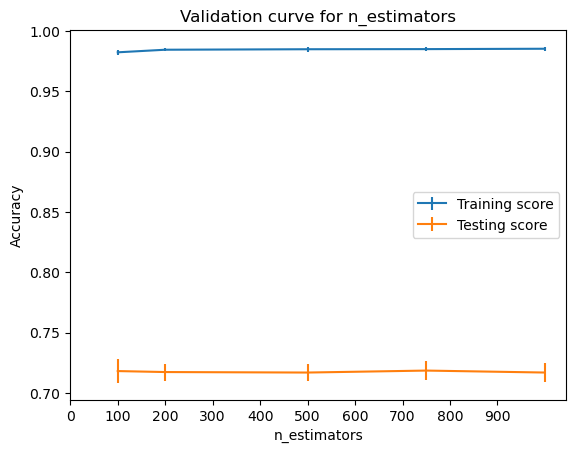

In [51]:
# plot validation curve for n_estimators
plt.errorbar(n_estimators_values, train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(n_estimators_values, test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 1000, 100))
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
_ = plt.title("Validation curve for n_estimators")

There is no clear benefit to having more than 100 trees/estimators in the forest.

In [52]:
# set n_estimators to 100
pipeline.set_params(randomforestclassifier__n_estimators=100)

# get results from tuned model
rfc_results = cross_validate(pipeline, features, target, cv=cross_val)

In [53]:
print('The mean accuracy with cross-validation is: ' 
      f'{rfc_results["test_score"].mean():.3f} +/- {rfc_results["test_score"].std():.3f}') 

The mean accuracy with cross-validation is: 0.718 +/- 0.010


### Gradient Boosted Decision Trees Model

In [4]:
# define preprocessor to encode categorical features
preprocessor = ColumnTransformer([
    ('categorical', OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1), categorical_columns)], 
    remainder = 'passthrough')

In [5]:
# hyperparameter tuning

# have to manually adjust weights to correct for class imbalance
# since HistGradientBoostingClassifier doesn't have a built-in class_weight parameter
sample_weights = compute_sample_weight(class_weight='balanced', y=target)

# define algorithm
hgbc = HistGradientBoostingClassifier(random_state=0, categorical_features=[0,1,2])

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, hgbc)

# hyperparameter values to try
param_grid =  {
    'histgradientboostingclassifier__learning_rate': [0.01, 0.05, 0.1, 0.5, 1, 2],
    'histgradientboostingclassifier__max_iter': [50, 100, 150, 200],
    'histgradientboostingclassifier__max_leaf_nodes': [8, 16, 32, 64, 128, 256]}

# CHANGE n_iter TO 500 LATER!!!
randomized_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=100, n_jobs=2)

cv_results = cross_validate(randomized_search, features, target, n_jobs=2, 
                            fit_params={'histgradientboostingclassifier__sample_weight': sample_weights}, 
                            return_estimator=True)

In [32]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with accuracy of {cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'histgradientboostingclassifier__max_leaf_nodes': 32, 'histgradientboostingclassifier__max_iter': 200, 'histgradientboostingclassifier__learning_rate': 0.05}
with accuracy of 0.676
Best hyperparameters for split #2:
{'histgradientboostingclassifier__max_leaf_nodes': 64, 'histgradientboostingclassifier__max_iter': 200, 'histgradientboostingclassifier__learning_rate': 0.1}
with accuracy of 0.661
Best hyperparameters for split #3:
{'histgradientboostingclassifier__max_leaf_nodes': 256, 'histgradientboostingclassifier__max_iter': 50, 'histgradientboostingclassifier__learning_rate': 0.1}
with accuracy of 0.688
Best hyperparameters for split #4:
{'histgradientboostingclassifier__max_leaf_nodes': 16, 'histgradientboostingclassifier__max_iter': 200, 'histgradientboostingclassifier__learning_rate': 0.1}
with accuracy of 0.690
Best hyperparameters for split #5:
{'histgradientboostingclassifier__max_leaf_nodes': 16, 'histgradientboostingclassifier__max_iter': 1

The best combination of hyperparameters seems to be n_estimators around 150, learning_rate of 0.05,  
but we need to take a closer look at max_leaf_nodes.  

In [37]:
# set tuned hyperparameters
pipeline.set_params(histgradientboostingclassifier__max_iter=150, histgradientboostingclassifier__learning_rate=0.05)

# hyperparameter values to try
param_grid =  {'histgradientboostingclassifier__max_leaf_nodes': [4, 8, 16, 32, 64, 128, 256]}

grid_search = GridSearchCV(pipeline, param_grid=param_grid, n_jobs=2)

cv_results = cross_validate(grid_search, features, target, n_jobs=2, 
                            fit_params={'histgradientboostingclassifier__sample_weight': sample_weights}, 
                            return_estimator=True)

In [38]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with accuracy of {cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'histgradientboostingclassifier__max_leaf_nodes': 64}
with accuracy of 0.678
Best hyperparameters for split #2:
{'histgradientboostingclassifier__max_leaf_nodes': 64}
with accuracy of 0.676
Best hyperparameters for split #3:
{'histgradientboostingclassifier__max_leaf_nodes': 32}
with accuracy of 0.698
Best hyperparameters for split #4:
{'histgradientboostingclassifier__max_leaf_nodes': 32}
with accuracy of 0.680
Best hyperparameters for split #5:
{'histgradientboostingclassifier__max_leaf_nodes': 16}
with accuracy of 0.706


max_leaf_nodes of 32 seem best

In [39]:
# set tuned hyperparameters
pipeline.set_params(histgradientboostingclassifier__max_leaf_nodes=32)

# get results from tuned model
gbc_results = cross_validate(pipeline, features, target, cv=cross_val,
                             fit_params={'histgradientboostingclassifier__sample_weight': sample_weights})

In [40]:
print('The mean accuracy with cross-validation is: ' 
      f'{gbc_results["test_score"].mean():.3f} +/- {gbc_results["test_score"].std():.3f}') 

The mean accuracy with cross-validation is: 0.684 +/- 0.020


## nssi_year

In [3]:
# drop records missing nssi_year for nssi_year models
nssi_year_data = data.dropna(subset='nssi_year')

# confirm new size of data set
nssi_year_data.shape

(2401, 18)

# Sandbox